In [ ]:
# -*- coding: utf-8 -*-
'''
论文题目：基于深度学习的PSA过程优化与控制
作    者：余秀鑫
单    位：天津大学化工学院
时    间：2022.04.12
'''

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import os
import time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

# 定义函数

In [2]:
def mse(y_true, y_pred):
  return tf.metrics.mean_squared_error(y_true=tf.squeeze(y_true),
                                       y_pred=tf.squeeze(y_pred))

In [3]:
def R2_Adj(y_true, y_pred):
    n, k = len(y_true), 7
    R2 = r2_score(y_true, y_pred)
    R2_Adj = 1 - (1 - R2) * (n - 1) / (n - k - 1)
    return R2_Adj

# 读取数据
keys = [
    "Energy",
    "CO2_Purity",
    "CO2_Recovery",
    "CO2_Productivity",
    "H2_Purity",
    "H2_Recovery",
    "H2_Productivity",
]

In [11]:
thisdata = "Energy"
x_train = np.load("../../results_of_sample1000\DL\Input.npy")
y_train = np.load("../../results_of_sample1000\DL/" + thisdata + ".npy")

In [12]:
scaler_x = MinMaxScaler(feature_range=(0, 1)).fit(x_train)
x_train_std = scaler_x.transform(x_train)
scaler_y = MinMaxScaler(feature_range=(0, 1)).fit(y_train)
y_train_std = scaler_y.transform(y_train)

In [13]:
np.random.seed(666)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_train)
np.random.seed(666)
np.random.shuffle(x_train_std)
np.random.seed(666)
np.random.shuffle(y_train)
np.random.seed(666)
np.random.shuffle(y_train_std)
tf.random.set_seed(666)

# 深度学习

## Create a model

In [20]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(17, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

## Compile the model

In [21]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,
                                       beta_1=0.9,
                                       beta_2=0.999),
    loss=tf.keras.losses.mse,
)

## Fit the model

In [23]:
def create_model_checkpoint(model_name, save_path="model_saved"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

In [24]:
history = model.fit(
    x_train_std,
    y_train_std,
    batch_size=64,
    epochs=2000,
    validation_split=0.2,
    validation_freq=1,
    verbose=0,
    callbacks=[create_model_checkpoint(model_name=thisdata)],
)

INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets written to: model_saved\Energy\assets
INFO:tensorflow:Assets w

## 计算准确度

In [11]:
y_pred_std = model.predict(x_train_std, batch_size=16)
acc = R2_Adj(y_train_std, y_pred_std)
print("R2_Adj_std: ", acc)

y_pred = scaler_y.inverse_transform(y_pred_std)
acc = R2_Adj(y_train, y_pred)
print("R2_Adj_scl: ", acc)

R2_Adj_std:  0.9955407959368471
R2_Adj_scl:  0.995540795283398


# 模型示意

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                136       
                                                                 
 dense_1 (Dense)             (None, 1)                 18        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


# 损失函数曲线 

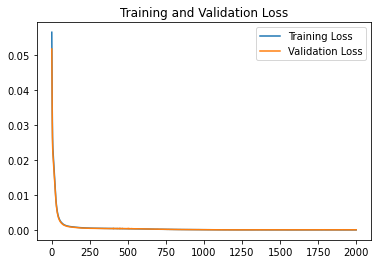

In [13]:
# 显示训练集和验证集的acc和loss曲线
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# 读取模型

In [14]:
load_model = tf.keras.models.load_model('model_saved/' + thisdata)
load_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 17)                136       
                                                                 
 dense_1 (Dense)             (None, 1)                 18        
                                                                 
Total params: 154
Trainable params: 154
Non-trainable params: 0
_________________________________________________________________


# 测试模型

## 读取测试集

In [15]:
x_test = np.load("../../results_of_sample300\DL\Input.npy")
y_test = np.load("../../results_of_sample300\DL/" + thisdata + ".npy")

In [16]:
x_test_std = scaler_x.transform(x_test)

In [17]:
y_pred_std = model.predict(x_test_std)
y_pred = scaler_y.inverse_transform(y_pred_std)

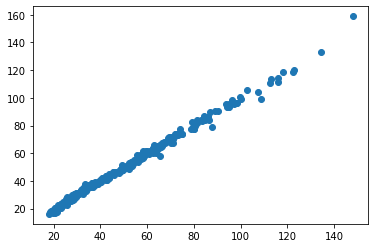

In [18]:
plt.scatter(y_pred,y_test)

In [19]:
r2_score(y_test, y_pred)

0.9945647324171795